# Visualisation
First imports:

In [1]:
import pandas as pd
import polars as pl
import random
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
FILE_PATH = 'MycroftMind_challenge_dataset.xlsx'

In [3]:
def print_sheet_names(file_path):
    data_file = pd.ExcelFile(file_path)
    names = list(data_file.sheet_names)[1:]
    print(f'Sheet names: {names}')
    for name in names:
        sheet_data = pd.read_excel(file_path, name)
        print(f'\t{name}\'s headers: {sheet_data.columns.to_list()}')

def merge_data(file_path):
    data_file = pd.ExcelFile(file_path)
    sheet_names = list(data_file.sheet_names[1:])
    merged_data = pd.read_excel(file_path, sheet_names[0]) #Imported and exported Energy
    next_data = pd.read_excel(file_path, sheet_names[1]) #Predicted energy
    merged_data = pd.merge(merged_data, next_data, on=['DeviceID', 'Timestamp'])
    next_data = pd.read_excel(file_path, sheet_names[2]).drop(columns=['Imported_energy (kWh)']) #Flexibility
    merged_data = pd.merge(merged_data, next_data, on=['DeviceID', 'Timestamp'])
    next_data = pd.read_excel(file_path, sheet_names[3]) #Battery
    merged_data = pd.merge(merged_data, next_data, on=['DeviceID', 'Timestamp'])
    next_data = pd.read_excel(file_path, sheet_names[4]) #Battery params 
    merged_data = pd.merge(merged_data, next_data, on=['DeviceID'], how='left')
    next_data = pd.read_excel(file_path, sheet_names[5]) #Weather
    merged_data = pd.merge(merged_data, next_data, on=['Timestamp'], how='left')
    next_data = pd.read_excel(file_path, sheet_names[6]) #Market prices
    merged_data = pd.merge(merged_data, next_data, on=['Timestamp'], how='left')
    return merged_data

def transform_columns(df: pl.DataFrame):
    return (
        df
        .with_columns(
            Timestamp=pl.col('Timestamp').str.to_datetime(),
            Local_demand=pl.col('Battery_capacity (kWh)') - pl.col('Stored_energy (kWh)'),
            Spot_Price_EUR=pl.col('Spot_Price (EUR/MWh)').str.replace(',', '.').cast(float),
            Spot_Price_CZK=pl.col('Spot_Price (CZK/MWh)').str.replace(',', '.').cast(float),
        )
        .drop(['Spot_Price (EUR/MWh)', 'Spot_Price (CZK/MWh)'])
    )

In [4]:
print_sheet_names(FILE_PATH)

Sheet names: ['Imported and Exported energy', 'Predicted energy', 'Flexibility', 'Battery', 'Battery parameters', 'Weather', 'Spot Market Prices']
	Imported and Exported energy's headers: ['DeviceID', 'Timestamp', 'Imported_energy (kWh)', 'Exported_energy (kWh)']
	Predicted energy's headers: ['DeviceID', 'Timestamp', 'Predicted_Imported_energy (kWh)', 'Predicted_Exported_energy (kWh)']
	Flexibility's headers: ['DeviceID', 'Timestamp', 'Imported_energy (kWh)', 'Flexible_consumption (kWh)', 'Flexibility_demand_amount [-1;1]', 'Flexibility_demand_price (CZK/MWh)']
	Battery's headers: ['DeviceID', 'Timestamp', 'Stored_energy (kWh)']
	Battery parameters's headers: ['DeviceID', 'Battery_capacity (kWh)', 'Max_charge_rate (kW)', ' Init_capacity (%)']
	Weather's headers: ['Timestamp', 't_2m:C', 't_apparent:C', 'relative_humidity_2m:p', 'precip_15min:mm', 'diffuse_rad:W', 'direct_rad:W', 'global_rad:W', 'wind_speed_10m:ms', 'wind_dir_10m:d', 'uv:idx']
	Spot Market Prices's headers: ['Timestamp',

In [5]:
print("Merged DataFrame:")
data = merge_data(FILE_PATH)
data

Merged DataFrame:


,DeviceID,Timestamp,Imported_energy (kWh),Exported_energy (kWh),Predicted_Imported_energy (kWh),Predicted_Exported_energy (kWh),Flexible_consumption (kWh),Flexibility_demand_amount [-1;1],Flexibility_demand_price (CZK/MWh),Stored_energy (kWh),...,relative_humidity_2m:p,precip_15min:mm,diffuse_rad:W,direct_rad:W,global_rad:W,wind_speed_10m:ms,wind_dir_10m:d,uv:idx,Spot_Price (EUR/MWh),Spot_Price (CZK/MWh)
0,OM1,2024-01-01 00:00:00,0.044,0.0,0.038339,0.0,0.000,-0.456757,921.550783,7.000,...,99.3,0.00,0.0,0.0,0.0,0.7,9.8,0.0,"0,1","2,47"
1,OM1,2024-01-01 00:05:00,0.040,0.0,0.036386,0.0,0.000,-0.617518,855.522083,6.956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OM1,2024-01-01 00:10:00,0.040,0.0,0.037537,0.0,0.000,-0.915563,1007.028267,6.916,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OM1,2024-01-01 00:15:00,0.038,0.0,0.045759,0.0,0.000,-0.506675,883.924399,6.876,...,97.6,0.03,0.0,0.0,0.0,1.1,48.9,0.0,NaN,NaN
4,OM1,2024-01-01 00:20:00,0.056,0.0,0.057124,0.0,0.000,-0.460941,576.059459,6.838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44635,OM5,2024-01-31 23:35:00,0.083,0.0,0.095046,0.0,0.043,-0.025611,-949.679349,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44636,OM5,2024-01-31 23:40:00,0.082,0.0,0.078978,0.0,0.042,-0.030342,-1328.257315,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44637,OM5,2024-01-31 23:45:00,0.073,0.0,0.081320,0.0,0.033,-0.028628,-1424.861971,0.000,...,95.5,0.00,0.0,0.0,0.0,1.6,202.0,0.0,NaN,NaN
44638,OM5,2024-01-31 23:50:00,0.074,0.0,0.083856,0.0,0.034,-0.028351,-829.226439,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def get_applied(dataFrame, fn, col1, col2):
    return dataFrame.apply(lambda row: fn(row.iloc[col1], row.iloc[col2]), axis=1)

def print_info(col):
    print(f'Min: {col.min()}, max: {col.max()}, mean: {col.mean()}, var: {col.var()}')

def distance(x, y):
    return abs(x - y)

In [7]:
print('Imported - exported')
print_info(get_applied(data, distance, 2, 3))
print('Predicted imported - predicted imported')
print_info(get_applied(data, distance, 4, 5))
print('Imported - predicted imported')
print_info(get_applied(data, distance, 2, 4))
print('Exported - predicted exported')
print_info(get_applied(data, distance, 3, 5))

Imported - exported
Min: 0.0, max: 1.2556019999999999, mean: 0.10849018727598583, var: 0.01692019551909227
Predicted imported - predicted imported
Min: 0.0, max: 1.2584801447444867, mean: 0.1086471601904246, var: 0.016949118611364583
Imported - predicted imported
Min: 0.0, max: 0.03921271860298249, mean: 0.0052224492633653335, var: 1.883875872871431e-05
Exported - predicted exported
Min: 0.0, max: 0.03035974111923112, mean: 0.002209149872162128, var: 1.487883820560865e-05


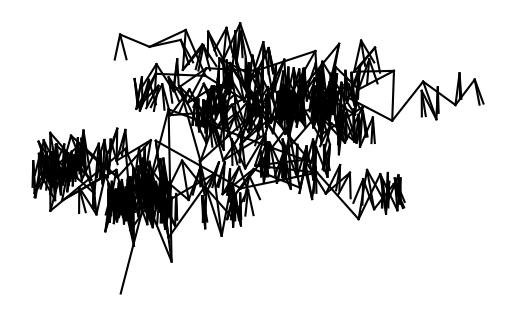

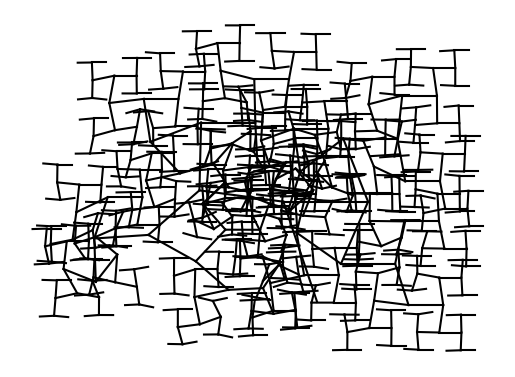

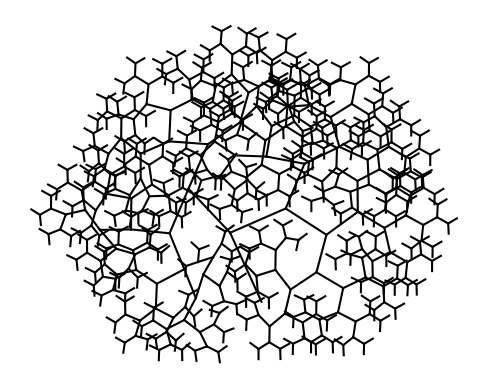

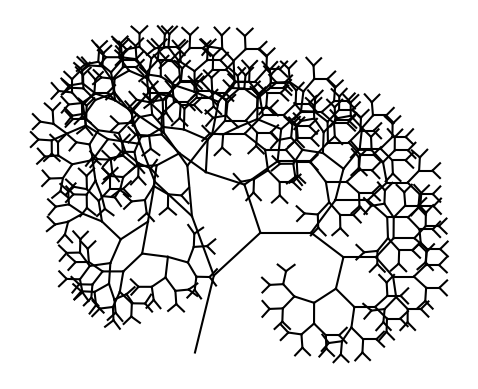

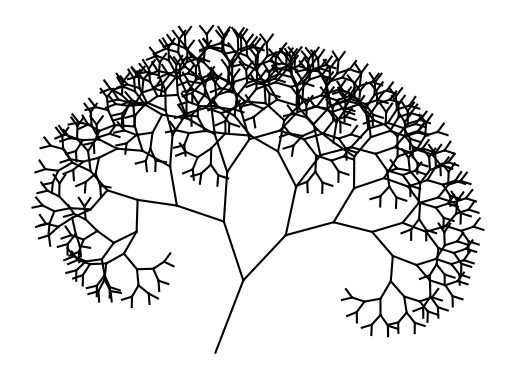

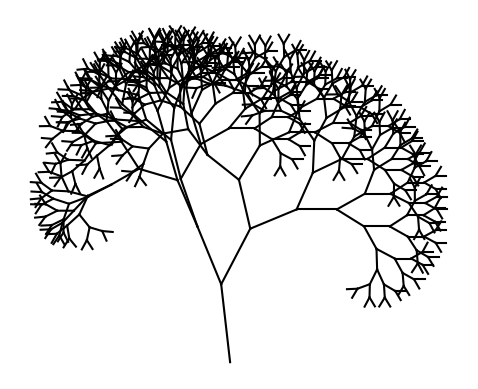

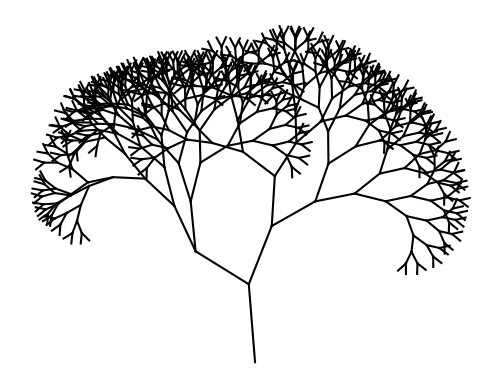

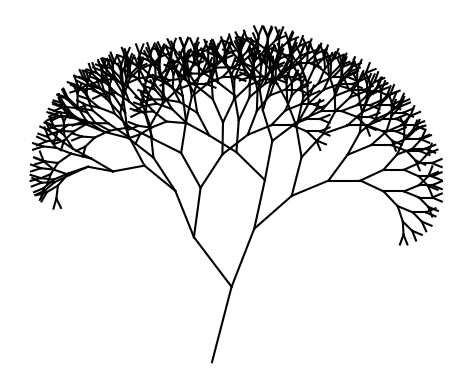

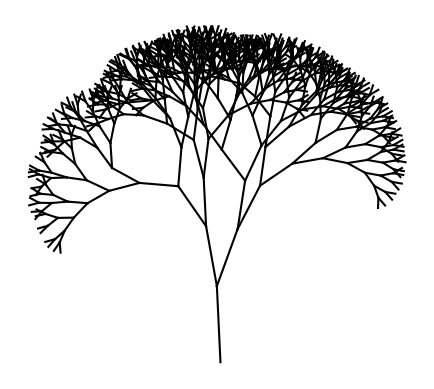

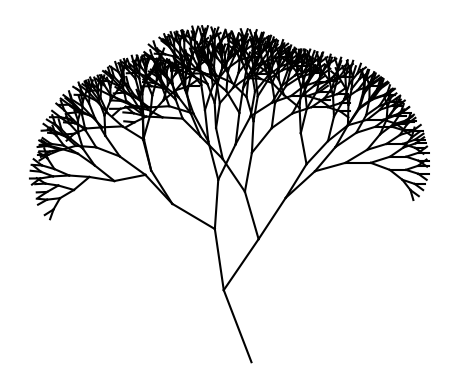

In [8]:
def draw_branch(ax, x, y, length, angle, depth, branch_angle, branch_ratio, pertub_fn):
    if depth == 0:
        return

    # Calculate the end point of the branch
    pertubation = pertub_fn(depth)
    x_end = x + length * np.cos(angle * pertubation)
    y_end = y + length * np.sin(angle * pertubation)

    # Draw the branch
    ax.plot([x, x_end], [y, y_end], 'k-')

    # Recursively draw the next branches
    new_length = length * branch_ratio
    draw_branch(ax, x_end, y_end, new_length, angle - branch_angle, depth - 1, branch_angle, branch_ratio, pertub_fn)
    draw_branch(ax, x_end, y_end, new_length, angle + branch_angle, depth - 1, branch_angle, branch_ratio, pertub_fn)

def draw_fractal_tree(depth, branch_angle=np.pi / 4, branch_ratio=0.7, pertub_fn = lambda x: 1):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.axis('off')

    # Start with the main trunk
    draw_branch(ax, 0, 0, 100, np.pi / 2, depth, branch_angle, branch_ratio, pertub_fn)

    plt.show()

# Parameters for the fractal tree
depth = 10  # Depth of recursion
branch_angle = np.pi  # Angle between branches (45 degrees)
branch_ratio = 0.8  # Ratio of branch length to parent branch length

# Draw the fractal tree
for i in range(10):
    draw_fractal_tree(depth, branch_angle / (i + 1), branch_ratio, lambda x: random.uniform(1 - x/(3 * depth), 1 + x/(3 * depth)))

In [9]:
class Branch:
    def __init__(self, start, end, angle):
        self.start = start
        self.end = end
        self.angle = angle

    def length(self):
        return math.sqrt((self.end[0] - self.start[0]) ** 2 + (self.end[1] - self.start[1]) ** 2)

    def next_left(self, generation, branch_ratio, branch_angle, pertubation):
        length = self.length() * branch_ratio ** generation
        angle = self.angle + branch_angle
        angle = angle * pertubation
        end = [self.end[0] + length * np.cos(angle), self.end[1] + length * np.sin(angle)]
        return Branch(start=self.end, end=end, angle=angle)

    def next_right(self, generation, branch_ratio, branch_angle, pertubation):
        length = self.length() * branch_ratio ** generation
        angle = self.angle - branch_angle
        angle = angle * pertubation
        end = [self.end[0] + length * np.cos(angle), self.end[1] + length * np.sin(angle)]
        return Branch(start=self.end, end=end, angle=angle)

class Tree:
    def __init__(self, start_angle):
        self.open_branches = {}
        self.closed_branches = {}
        self.open_branches[''] = Branch([1, 0], [1, 100], start_angle)

    def draw(self):
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        ax.axis('off')
        for k, v in self.closed_branches.items():
            ax.plot([v.start[0], v.end[0]], [v.start[1], v.end[1]], color='brown', linewidth=1)
        for k, v in self.open_branches.items():
            ax.plot([v.start[0], v.end[0]], [v.start[1], v.end[1]], color='green', linewidth=1)
        plt.show()

    def next(self, branch_ratio, branch_angle, pertub_fn, score):
        next_open = {}
        split = score_split(score, self.open_branches)
        for k, v in split[0].items():
            pertubation = pertub_fn(len(k) + 1)
            next_open[k + '0'] = v.next_left(len(k), branch_ratio, branch_angle, pertubation)
            pertubation = pertub_fn(len(k) + 1)
            next_open[k + '1'] = v.next_right(len(k), branch_ratio, branch_angle, pertubation)
        self.closed_branches = self.closed_branches | split[0]
        self.open_branches = next_open | split[1]

def pertubation(level, depth):
    if (level > 3):
        return random.uniform(1 - level / (4 * depth), 1 + level / (4 * depth))
    else:
        return random.uniform(0.7, 1.2)

def score_split(probability, data):
    selected_items = {}
    retained_items = {}
    for key, value in data.items():
        if random.random() < probability:
            selected_items[key] = value
        else:
            retained_items[key] = value
    return [selected_items, retained_items]
        

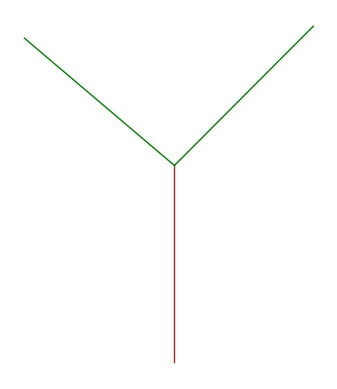

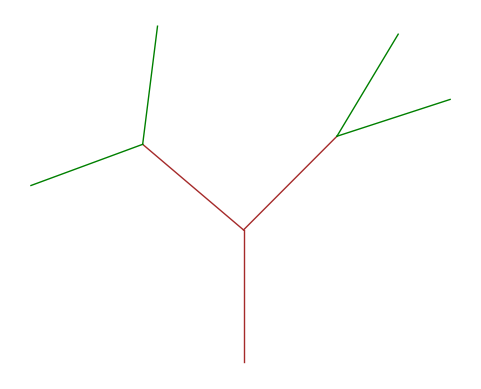

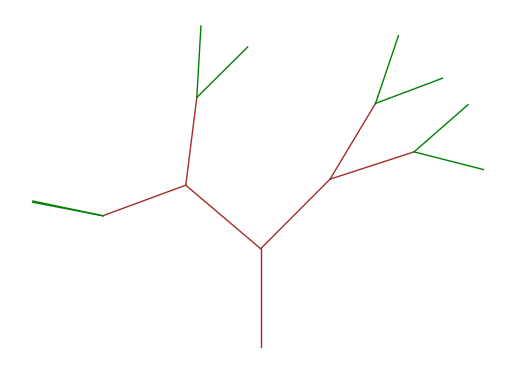

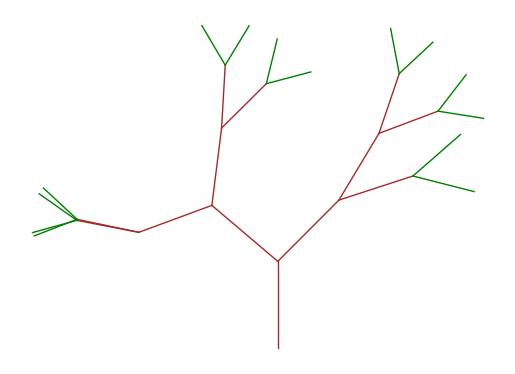

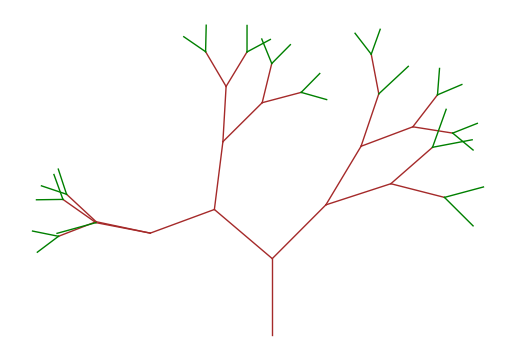

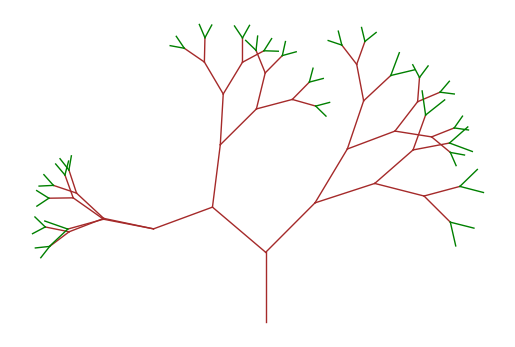

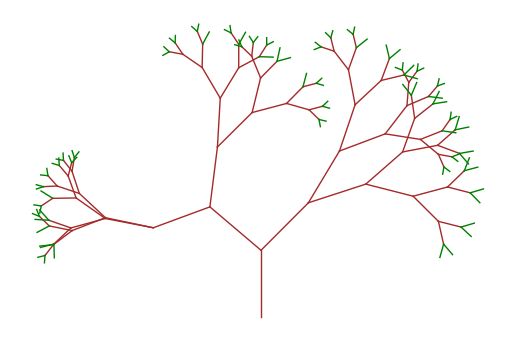

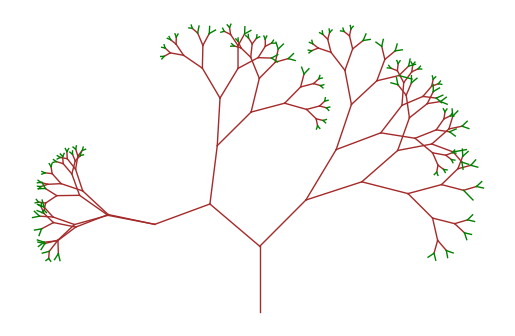

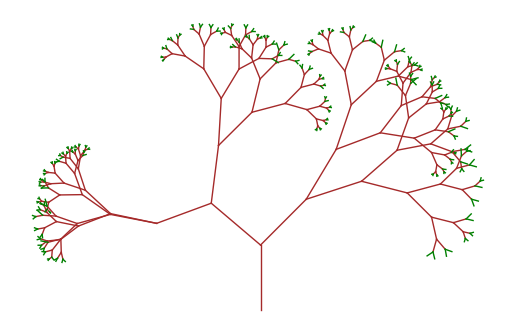

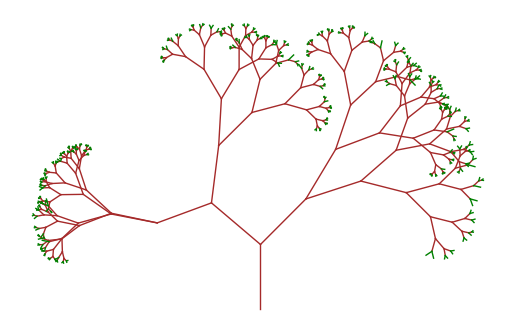

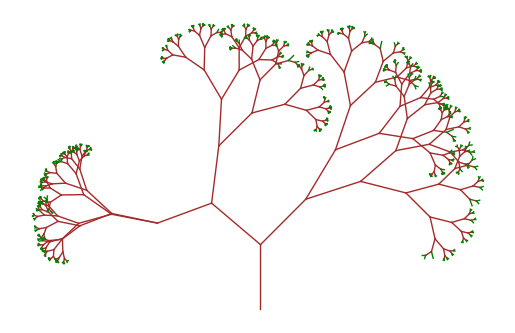

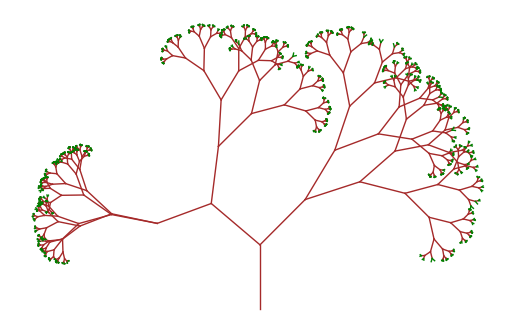

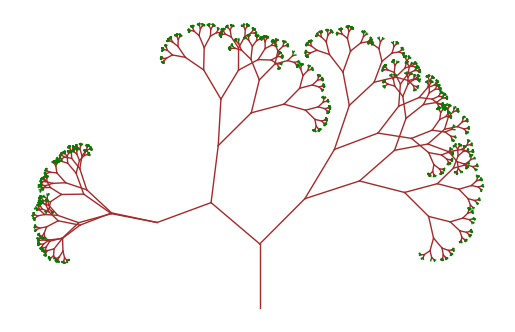

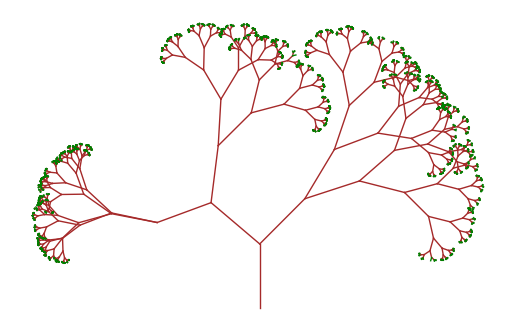

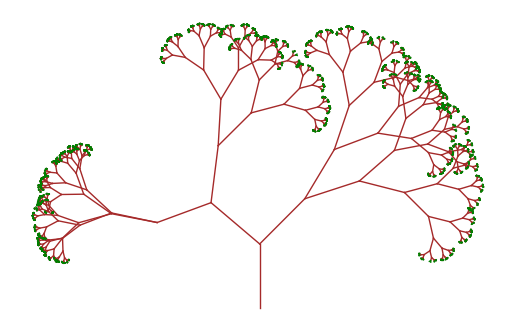

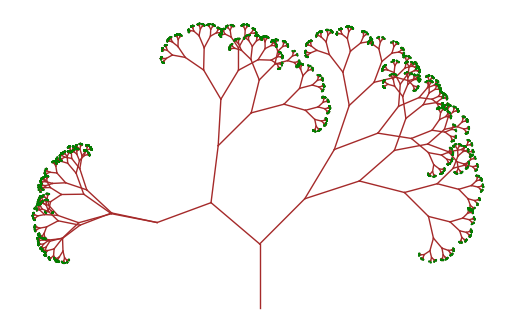

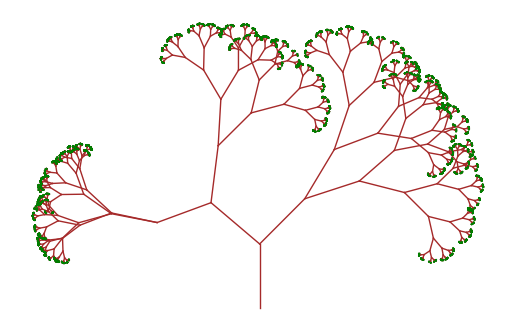

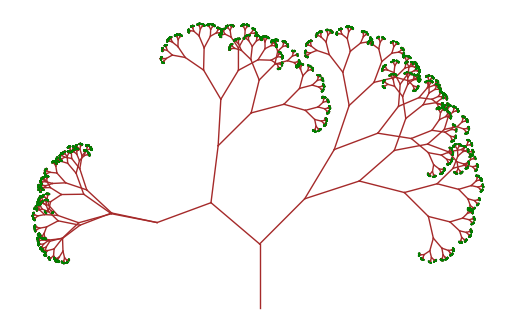

In [ ]:
tree = Tree(np.pi / 2)
depth = 20
for i in range(depth):
    tree.draw()
    score = random.uniform(0.5, 1)
    tree.next(0.9, np.pi / 6, lambda x: pertubation(x, depth), score)
tree.draw()